# Model

Given that a crime happened associated to a 
(premis	,latitude,	longitude,	year	,holiday	,hour	,no_of_month,	Day_of_month,	no_of_weekday) tuple,
what's the relative probability for that crime to be a given law category type?

## Setup

In [2]:
import numpy as np
import pandas as pd

from IPython.display import display

import matplotlib  
import matplotlib.pyplot as plt  
from matplotlib import rcParams

import seaborn as sns
sns.set(style='ticks', palette='Set2')

from plotnine import *
from pandas.core import datetools

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [3]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [4]:
pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 9999)

## Dataset

In [5]:
# Retrieving Data

df=pd.read_csv('cleaned.csv')
df = df[df.premise.notnull() & df.occurence.notnull() & df.borough.notnull()]
df.head(1)

,from_date,from_time,to_date,to_time,offense,offense_description,law_category,occurence,premise,borough,latitude,longitude,year,Month,weekday,holiday,hour,time_str,time,no_of_month,Day_of_month,no_of_weekday,offense_cutoff
0,2017-03-31,23:30:00,NaN,NaN,HARRASSMENT 2,"HARASSMENT,SUBD 3,4,5",VIOLATION,INSIDE,RESIDENCE - APT. HOUSE,BROOKLYN,40.638018,-73.898491,2017,Mar,Friday,0,23,2017-03-31 23:30:00,2017-03-31 23:30:00,3,31,4,HARRASSMENT 2


## Preprocessing

In [6]:
premise_map = {
  'ABANDONED BUILDING': 'BUILDING',
  'AIRPORT TERMINAL': 'TRANSPORTATION',
  'ATM': 'BANK',
  'BANK': 'BANK',
  'BAR/NIGHT CLUB': 'CLUB',
  'BEAUTY & NAIL SALON': 'BUSINESS',
  'BOOK/CARD': 'BUSINESS',
  'BRIDGE': 'STREET',
  'BUS (NYC TRANSIT)': 'TRANSPORTATION',
  'BUS (OTHER)': 'TRANSPORTATION',
  'BUS STOP': 'TRANSPORTATION',
  'BUS TERMINAL': 'TRANSPORTATION',
  'CANDY STORE': 'BUSINESS',
  'CEMETERY': 'LANDMARK',
  'CHAIN STORE': 'BUSINESS',
  'CHECK CASHING BUSINESS': 'BANK',
  'CHURCH': 'CHURCH',
  'CLOTHING/BOUTIQUE': 'BUSINESS',
  'COMMERCIAL BUILDING': 'BUSINESS',
  'CONSTRUCTION SITE': 'LANDMARK',
  'DEPARTMENT STORE': 'BUSINESS',
  'DOCTOR/DENTIST OFFICE': 'BUSINESS',
  'DRUG STORE': 'BUSINESS',
  'DRY CLEANER/LAUNDRY': 'BUSINESS',
  'FACTORY/WAREHOUSE': 'BUSINESS',
  'FAST FOOD': 'BUSINESS',
  'FERRY/FERRY TERMINAL': 'TRANSPORTATION',
  'FOOD SUPERMARKET': 'BUSINESS',
  'GAS STATION': 'BUSINESS',
  'GROCERY/BODEGA': 'BUSINESS',
  'GYM/FITNESS FACILITY': 'BUSINESS',
  'HIGHWAY/PARKWAY': 'STREET',
  'HOSPITAL': 'HOSPITAL',
  'HOTEL/MOTEL': 'HOTEL',
  'JEWELRY': 'BUSINESS',
  'LIQUOR STORE': 'BUSINESS',
  'LOAN COMPANY': 'BANK',
  'MARINA/PIER': 'TRANSPORTATION',
  'MOSQUE': 'CHURCH',
  'OPEN AREAS (OPEN LOTS)': 'LANDMARK',
  'OTHER': 'OTHER',
  'OTHER HOUSE OF WORSHIP': 'CHURCH',
  'PARK/PLAYGROUND': 'LANDMARK',
  'PARKING LOT/GARAGE (PRIVATE)': 'PARKING',
  'PARKING LOT/GARAGE (PUBLIC)': 'PARKING',
  'PHOTO/COPY': 'BUSINESS',
  'PRIVATE/PAROCHIAL SCHOOL': 'CHURCH',
  'PUBLIC BUILDING': 'BUILDING',
  'PUBLIC SCHOOL': 'SCHOOL',
  'RESIDENCE - APT. HOUSE': 'RESIDENCE',
  'RESIDENCE - PUBLIC HOUSING': 'RESIDENCE',
  'RESIDENCE-HOUSE': 'RESIDENCE',
  'RESTAURANT/DINER': 'BUSINESS',
  'SHOE': 'BUSINESS',
  'SMALL MERCHANT': 'BUSINESS',
  'SOCIAL CLUB/POLICY': 'BUILDING',
  'STORAGE FACILITY': 'BUSINESS',
  'STORE UNCLASSIFIED': 'BUSINESS',
  'STREET': 'STREET',
  'SYNAGOGUE': 'CHURCH',
  'TAXI (LIVERY LICENSED)': 'TAXI',
  'TAXI (YELLOW LICENSED)': 'TAXI',
  'TAXI/LIVERY (UNLICENSED)': 'TAXI',
  'TELECOMM. STORE': 'BUSINESS',
  'TRAMWAY': 'TRANSPORTATION',
  'TRANSIT - NYC SUBWAY': 'TRANSPORTATION',
  'TRANSIT FACILITY (OTHER)': 'TRANSPORTATION',
  'TUNNEL': 'STREET',
  'VARIETY STORE': 'BUSINESS',
  'VIDEO STORE': 'BUSINESS'
}

In [7]:
dft = df.copy()
dft.drop(['from_date', 'from_time', 'to_date', 'to_time', 'offense', 'borough', 'occurence', 'offense_description','Month','weekday', 'time_str', 'offense_cutoff', 'time'], axis = 1, inplace = True)
display(dft.head(1))

law_categories = dft.law_category.unique()
law_category_encoder = dict(zip(law_categories, range(len(law_categories))))
law_category_decoder = dict(zip(range(len(law_categories)), law_categories))

dft['law_category'] = dft.law_category.map(lambda v: law_category_encoder[v])
dft['premise'] = dft.premise.map(lambda v: premise_map[v])

dft = pd.get_dummies(dft, prefix="", prefix_sep="", columns=["premise"])
dft.head(1)

,law_category,premise,latitude,longitude,year,holiday,hour,no_of_month,Day_of_month,no_of_weekday
0,VIOLATION,RESIDENCE - APT. HOUSE,40.638018,-73.898491,2017,0,23,3,31,4


,law_category,latitude,longitude,year,holiday,hour,no_of_month,Day_of_month,no_of_weekday,BANK,BUILDING,BUSINESS,CHURCH,CLUB,HOSPITAL,HOTEL,LANDMARK,OTHER,PARKING,RESIDENCE,SCHOOL,STREET,TAXI,TRANSPORTATION
0,0,40.638018,-73.898491,2017,0,23,3,31,4,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


#### Train test split

In [8]:
from sklearn.cross_validation import train_test_split

# stratified sample
dft_sample = pd.concat([
    dft[dft.law_category==0].sample(10000, random_state=1),
    dft[dft.law_category==1].sample(10000, random_state=1),
    dft[dft.law_category==2].sample(10000, random_state=1)
])

features_list = dft_sample.drop(['law_category','year'],axis=1).columns.values

X = dft_sample[features_list].values
y = dft_sample['law_category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/bernadett/miniconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [9]:
dft_sample.corr()

,law_category,latitude,longitude,year,holiday,hour,no_of_month,Day_of_month,no_of_weekday,BANK,BUILDING,BUSINESS,CHURCH,CLUB,HOSPITAL,HOTEL,LANDMARK,OTHER,PARKING,RESIDENCE,SCHOOL,STREET,TAXI,TRANSPORTATION
law_category,1.000000,0.027490,-0.017482,-0.018598,-0.005939,-0.018604,0.010620,-0.000005,0.017459,0.003881,0.024186,0.127715,-0.007347,0.020214,-0.022184,0.001057,0.006451,-0.003370,0.040437,-0.177024,-0.064889,0.108050,0.009290,0.004529
latitude,0.027490,1.000000,0.337716,0.011477,-0.005277,-0.003792,-0.019521,0.005118,0.004607,0.004541,0.000101,0.000261,-0.010186,0.004792,0.000367,0.006869,0.002447,0.008271,-0.004959,-0.016419,0.016573,0.008951,0.007602,0.001679
longitude,-0.017482,0.337716,1.000000,0.006991,-0.004054,0.009163,-0.010889,0.002063,0.009955,-0.013439,-0.019011,-0.087499,-0.015661,-0.051634,-0.007870,-0.031033,-0.012845,0.010232,0.016770,0.073710,0.001879,0.018742,-0.007116,-0.034100
year,-0.018598,0.011477,0.006991,1.000000,0.020335,-0.003913,-0.286862,-0.005355,0.000758,0.005321,-0.000403,0.035672,-0.000017,0.015041,0.009888,0.019602,-0.003899,0.004168,-0.018744,0.009545,-0.007907,-0.051640,0.017761,0.003202
holiday,-0.005939,-0.005277,-0.004054,0.020335,1.000000,-0.012085,-0.007399,-0.046878,-0.180098,-0.009584,0.001709,-0.007160,-0.005309,-0.002254,-0.003853,-0.005337,0.003001,-0.008212,0.004674,0.019252,-0.019181,-0.002346,-0.006723,-0.009206
hour,-0.018604,-0.003792,0.009163,-0.003913,-0.012085,1.000000,-0.001263,0.020652,-0.051547,-0.012261,-0.012301,0.050912,0.008164,-0.094968,-0.003633,-0.010409,0.007384,-0.009700,0.013283,-0.018285,-0.031183,0.021439,-0.012744,-0.001565
no_of_month,0.010620,-0.019521,-0.010889,-0.286862,-0.007399,-0.001263,1.000000,0.020614,0.000186,-0.009017,0.003123,0.004942,-0.002103,-0.007062,-0.002855,0.000375,0.011338,-0.001839,0.007942,-0.016365,-0.009878,0.020020,-0.003266,0.002269
Day_of_month,-0.000005,0.005118,0.002063,-0.005355,-0.046878,0.020652,0.020614,1.000000,-0.003697,0.007627,0.000649,0.005127,-0.012728,0.007677,0.007456,0.002401,0.002259,0.005025,0.002060,-0.008350,-0.013881,0.001959,0.005044,0.008096
no_of_weekday,0.017459,0.004607,0.009955,0.000758,-0.180098,-0.051547,0.000186,-0.003697,1.000000,-0.015733,0.000959,-0.022248,-0.000477,0.054467,-0.008435,0.013264,-0.009931,-0.002552,0.002372,0.002448,-0.060791,0.027467,0.002309,-0.003213
BANK,0.003881,0.004541,-0.013439,0.005321,-0.009584,-0.012261,-0.009017,0.007627,-0.015733,1.000000,-0.007352,-0.037094,-0.005678,-0.009891,-0.006909,-0.006585,-0.006474,-0.014812,-0.009089,-0.089416,-0.011796,-0.042005,-0.003358,-0.004597


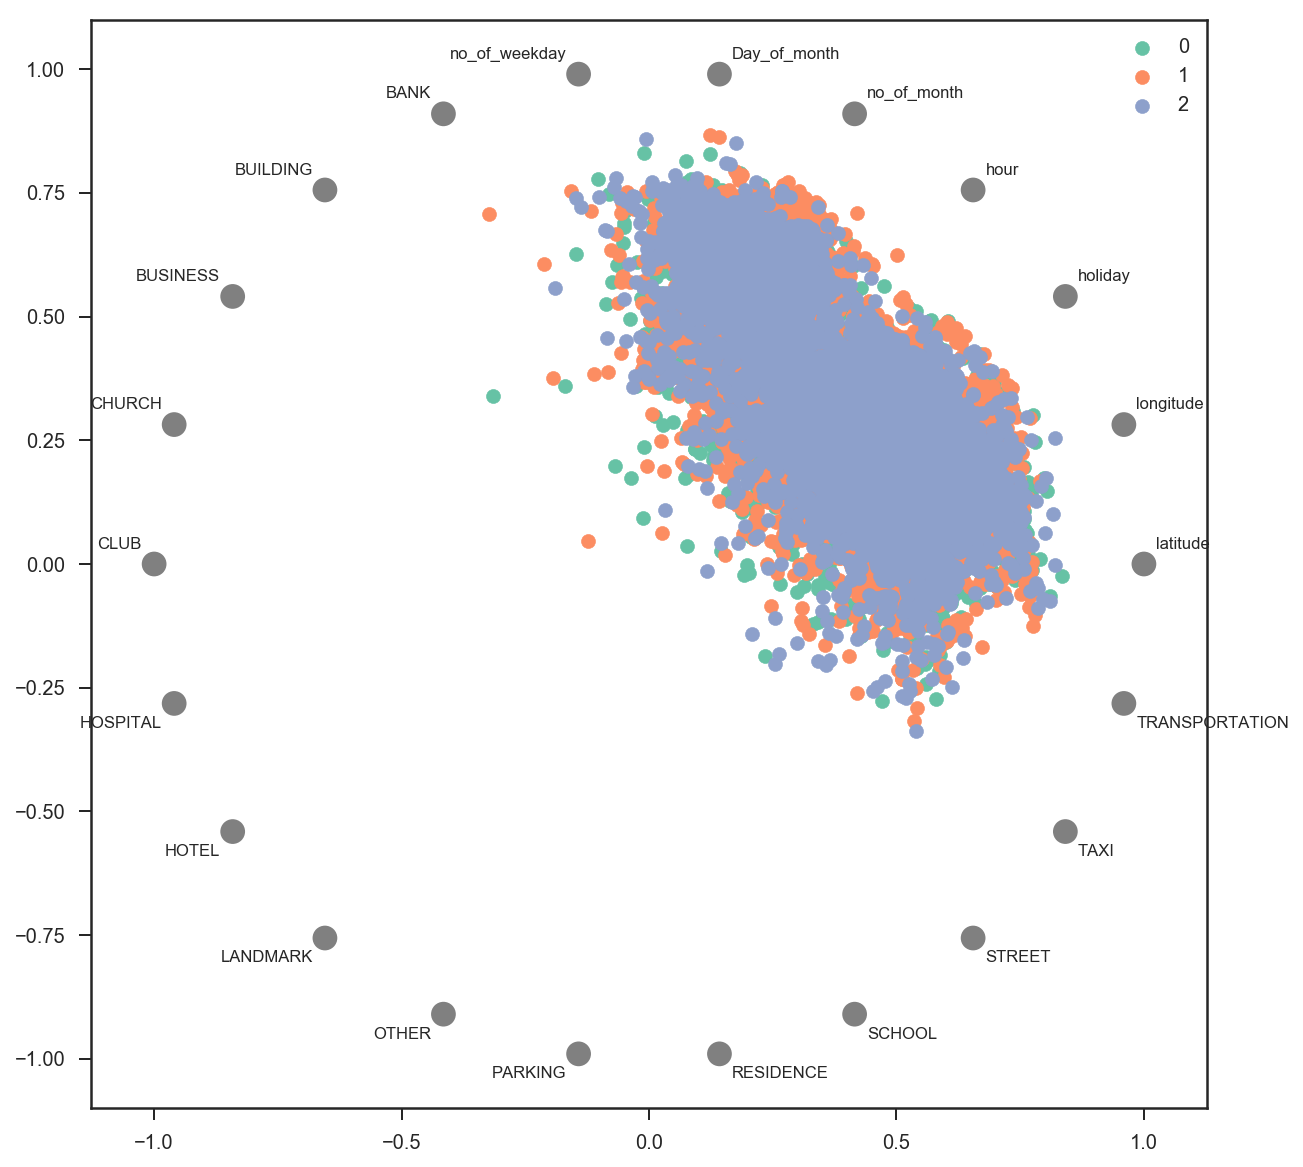

In [10]:
from pandas.plotting import radviz

plt.rcParams['figure.figsize']=10,10
radviz(dft_sample.drop(['year'],axis=1), 'law_category', color=sns.color_palette())

### Model selection

We're going to be using [logloss](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html) to evaluate our classifiers as we're interested in predicting probabilities

In [11]:
from sklearn.metrics import log_loss, accuracy_score, f1_score

def eval_classifier(clf):
    y_pred = clf.predict(X_test)
    y_pred_prob = clf.predict_proba(X_test)
    
    logloss = log_loss(y_test, y_pred_prob, labels=clf.classes_)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    
    print(type(clf).__name__, "logloss=%s accuracy=%s f1=%s" % (logloss, accuracy, f1))

In [12]:
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

classifiers = [
    LogisticRegression(),
    GaussianNB(),
    RandomForestClassifier(n_estimators=500),
    XGBClassifier(n_estimators=500)
]

for clf in classifiers:
    clf.fit(X_train, y_train)
    eval_classifier(clf)

RandomForestClassifier logloss=1.07835596972 accuracy=0.421733333333 f1=0.419678040012


In [13]:
dff = pd.DataFrame(list(zip(features_list, clf.feature_importances_)), columns=['feature', 'importance'])
dff.set_index('feature', inplace=True)
dff.sort_values(by='importance', ascending=False)

,importance
feature,
latitude,0.220610
longitude,0.219535
Day_of_month,0.162926
hour,0.142442
no_of_month,0.116531
no_of_weekday,0.086753
RESIDENCE,0.012996
BUSINESS,0.006569
STREET,0.006348


In [14]:
from sklearn.ensemble import VotingClassifier

classfier_names = [type(c).__name__ for c in classifiers]
estimators = list(zip(classfier_names, classifiers))

clf = VotingClassifier(estimators=estimators, voting='soft')
clf.fit(X_train, y_train)
eval_classifier(clf)

VotingClassifier logloss=1.07984084412 accuracy=0.420266666667 f1=0.417981655222


RandomForest seems to be performing better, sticking to it

In [15]:
# cross validation

from sklearn.cross_validation import cross_val_score
# from sklearn.metrics import log_loss
from sklearn import metrics

clf = RandomForestClassifier(n_estimators=500)
cross_val_score(clf, X, y, cv=5, scoring="neg_log_loss")

array([-1.08127617, -1.07923547, -1.08483214, -1.08355039, -1.08089314])

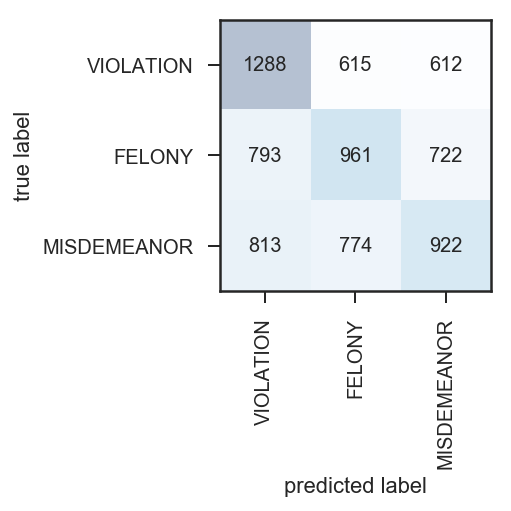

In [16]:
from mlxtend.plotting import plot_confusion_matrix
from mlxtend.evaluate import confusion_matrix

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

cm = confusion_matrix(y_target=y_test, y_predicted=y_pred, binary=False)

fig, ax = plot_confusion_matrix(conf_mat=cm)

classes = law_categories
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=90)
plt.yticks(tick_marks, classes)

plt.show()

In [17]:
from sklearn.metrics import classification_report

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=law_categories))

             precision    recall  f1-score   support

  VIOLATION       0.44      0.50      0.47      2515
     FELONY       0.41      0.39      0.40      2476
MISDEMEANOR       0.40      0.36      0.38      2509

avg / total       0.42      0.42      0.41      7500



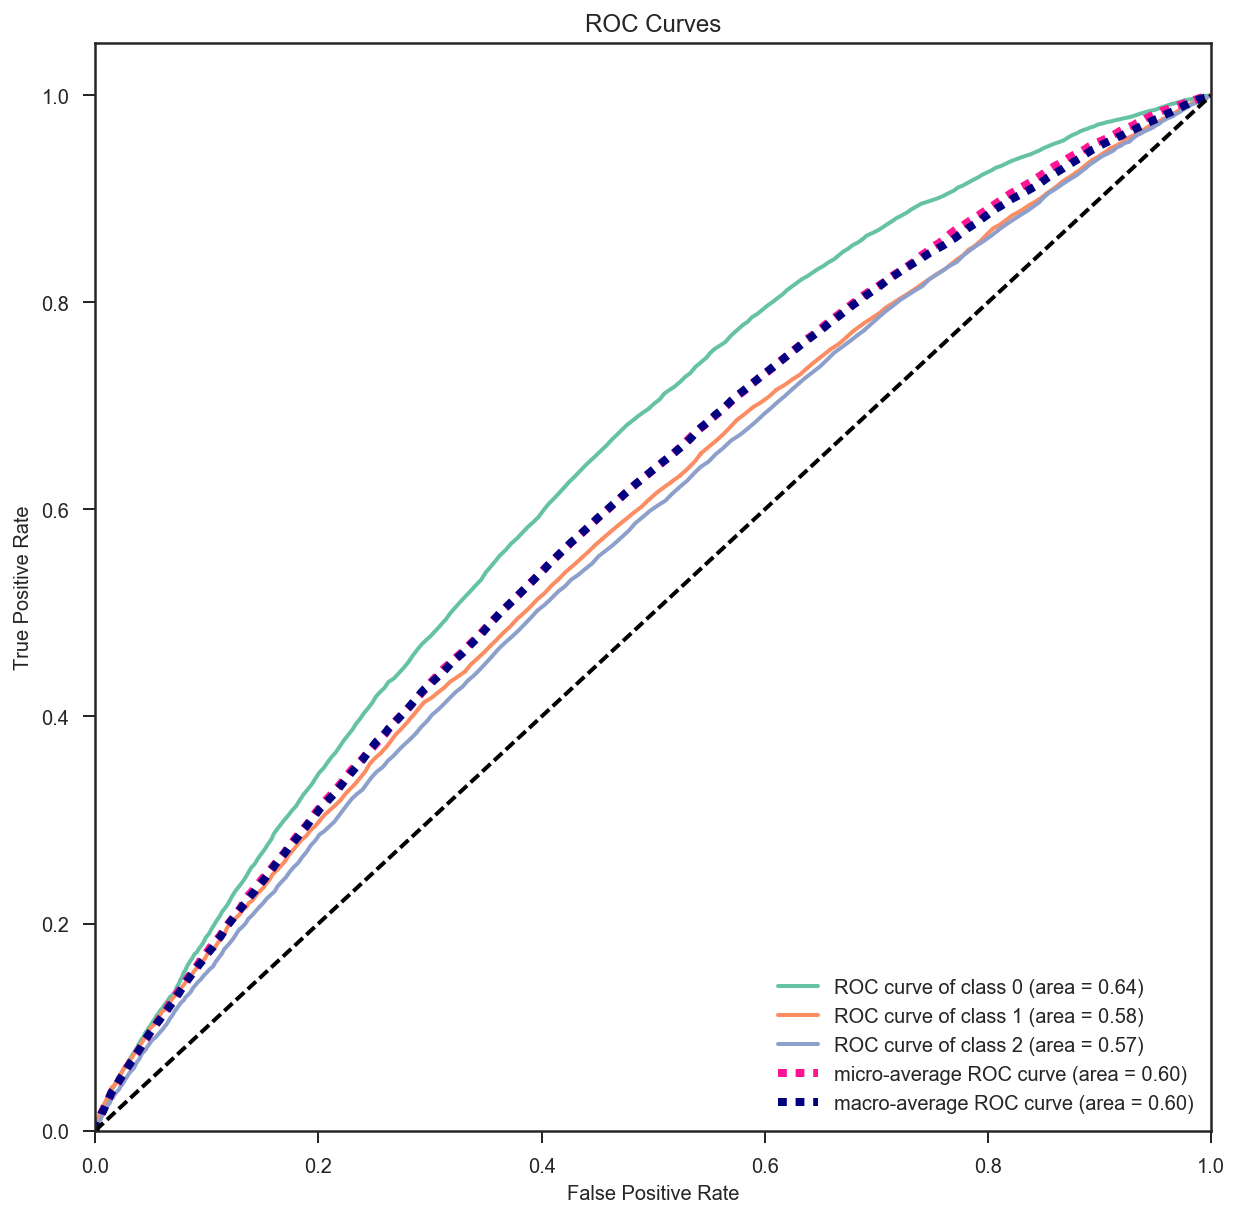

In [18]:
from scikitplot import classifier_factory

clf = RandomForestClassifier(n_estimators=500)
classifier_factory(clf)
clf.plot_roc_curve(X, y, random_state=1)
plt.show()

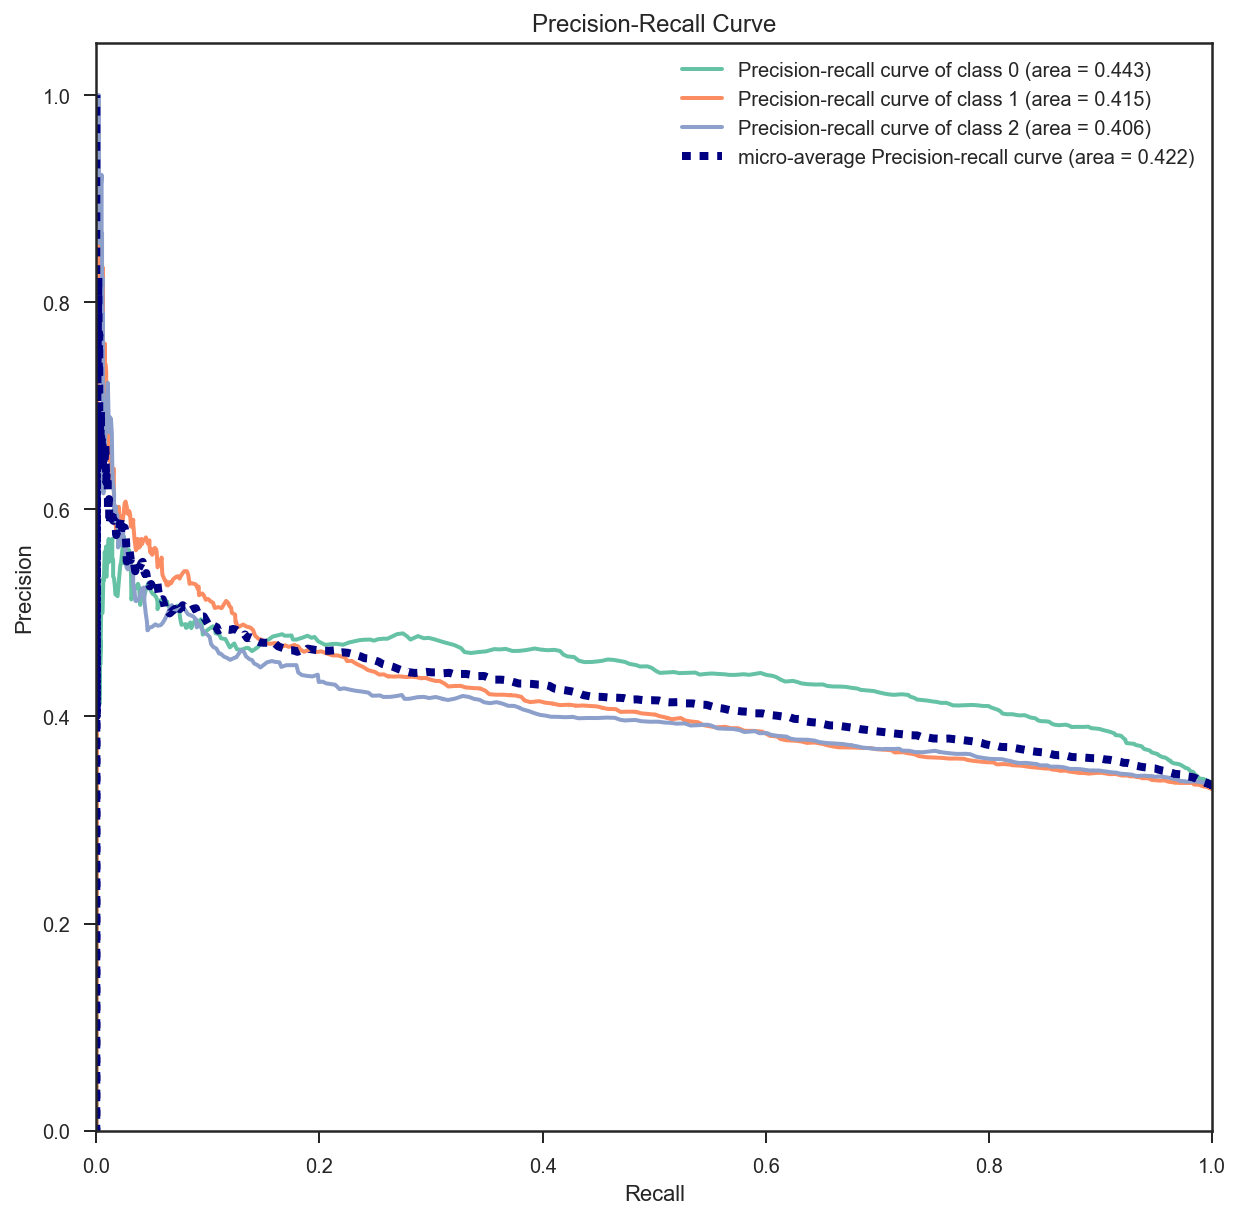

In [19]:
import scikitplot.plotters as skplt

clf = RandomForestClassifier(n_estimators=500)
clf.fit(X_train, y_train)
y_pred_prob = clf.predict_proba(X_test)

skplt.plot_precision_recall_curve(y_test, y_pred_prob)
plt.show()